In [1]:
#import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Data/Oil.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
df = df.drop(df.columns[0],axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7942 entries, 0 to 7941
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      7942 non-null   datetime64[ns]
 1   Price     7942 non-null   float64       
 2   Open      7942 non-null   float64       
 3   High      7942 non-null   float64       
 4   Low       7942 non-null   float64       
 5   Vol.      7942 non-null   object        
 6   Change %  7942 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 434.5+ KB


In [6]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,1990-11-30,29.20,32.05,32.45,29.05,4.00K,-9.85%
1,1990-12-03,29.72,29.00,30.35,28.50,15.48K,1.78%
2,1990-12-04,30.70,29.60,30.70,29.50,11.83K,3.30%
3,1990-12-05,27.33,29.60,30.30,27.30,23.48K,-10.98%
4,1990-12-06,26.80,27.30,28.00,25.45,24.73K,-1.94%
...,...,...,...,...,...,...,...
7937,2021-12-23,76.85,75.47,77.00,74.78,161.24K,2.07%
7938,2021-12-24,76.14,76.72,76.79,75.75,30.54K,-0.92%
7939,2021-12-27,78.60,76.32,79.08,75.75,85.39K,3.23%
7940,2021-12-28,78.94,78.67,79.85,78.48,50.41K,0.43%


In [7]:
cols = ['Price','Open','High','Low'] #the columns that will be used in the prediction
#Normlizing the selected columns
scaler = StandardScaler()
scaler = scaler.fit(df[cols])
data = scaler.transform(df[cols])

In [8]:
dates = df['Date'] #seperating the data for visualization purpose

In [9]:
def to_sequence(data, n_past=10, n_future=1):
  '''
  This function purpose is to restructure the sequence data in 
  a normal feature and target format

  This function assumes that the target is the first column in the data

  parameters:
  data: the data to be processed
  n_past: the number of steps in the past used to predict the future
  n_future: the number of steps in future to be predicted

  return:
  the function returns a tuple of the features (X) and target (Y)
  '''
  X = []
  Y = []
  for i in range(n_past, len(data) - n_future +1):
    X.append(data[i - n_past:i, 0:data.shape[1]])
    Y.append(data[i + n_future - 1:i + n_future, 0]) #

  return X,Y


In [10]:
#seperating the last 5 years for testing and rest for training
last_5_years = len(df[df['Date'] >= '2016-1-1'])
train = data[:-last_5_years,:]
test = data[-last_5_years:,:]
dates_training = dates[:-last_5_years]
dates_testing = dates[-last_5_years:]
train.shape,test.shape

((6394, 4), (1548, 4))

In [11]:
trainX,trainY = to_sequence(train, n_past=10)
testX,testY = to_sequence(test, n_past=10)

In [12]:
#converting data to numpy
trainX, trainY, testX, testY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY)

In [13]:
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))
print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

trainX shape == (6384, 10, 4).
trainY shape == (6384, 1).
testX shape == (1538, 10, 4).
testY shape == (1538, 1).


In [22]:
#constructing the LSTM model
model = Sequential()
model.add(LSTM(64, activation = 'relu', input_shape = (trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

In [23]:
#optimizer is Adam, loss function is mean square error
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 64)            17664     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30,113
Trainable params: 30,113
Non-trainable params: 0
_________________________________________________________________


In [25]:
#training the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/5
360/360 [==============================] - 11s 19ms/step - loss: 0.0710 - val_loss: 0.0142
Epoch 2/5
360/360 [==============================] - 4s 10ms/step - loss: 0.0326 - val_loss: 0.0081
Epoch 3/5
360/360 [==============================] - 4s 10ms/step - loss: 0.0320 - val_loss: 0.0087
Epoch 4/5
360/360 [==============================] - 3s 10ms/step - loss: 0.0316 - val_loss: 0.0359
Epoch 5/5
360/360 [==============================] - 3s 9ms/step - loss: 0.0319 - val_loss: 0.0045


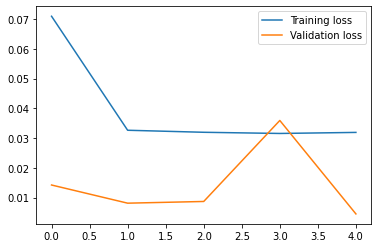

In [26]:
#ploting the model performance
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [27]:
#forcasting the the testing data
forcast = model.predict(testX)

forcast.shape

(1538, 1)

In [28]:
#inverse the normlization
forcast_copies = np.repeat(forcast, 4, axis=-1)
forcast_not_nomalized = scaler.inverse_transform(forcast_copies)[:,0]

In [29]:
#inverse the normlization
testY_copies = np.repeat(testY, 4, axis=-1)
testY_not_nomalized = scaler.inverse_transform(testY_copies)[:,0]

Text(0.5, 1.0, 'predicted vs actual price')

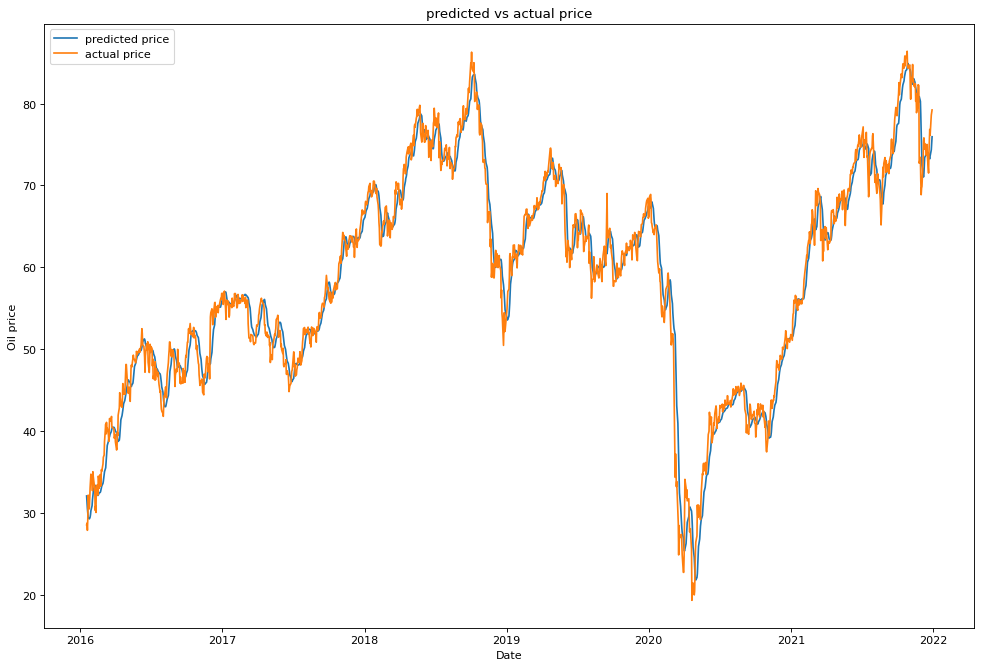

In [36]:
n_past = 10
plt.figure(figsize=(15, 10), dpi=80)
plt.plot(dates_testing[n_past:],forcast_not_nomalized, label='predicted price')
plt.plot(dates_testing[n_past:],testY_not_nomalized, label='actual price')
plt.legend()
plt.ylabel('Oil price')
plt.xlabel('Date')
plt.title('predicted vs actual price')

In [37]:
sample = [[79.32,79.19,79.66,78.5],[79.23,79.28,80.17,78.13],[78.94,78.67,79.85,78.48],[78.6,76.32,79.08,75.75],[76.14,76.72,76.79,75.75],[76.85,75.47,77,74.78],[75.29,74.05,75.67,73.62],[73.98,71.88,74.27,71.24],[71.52,72.82,72.87,69.28],[73.52,74.5,74.98,72.65]]

In [38]:
s = np.array(sample)

In [43]:
s = s.reshape((1,10,4))
s

array([[[79.32, 79.19, 79.66, 78.5 ],
        [79.23, 79.28, 80.17, 78.13],
        [78.94, 78.67, 79.85, 78.48],
        [78.6 , 76.32, 79.08, 75.75],
        [76.14, 76.72, 76.79, 75.75],
        [76.85, 75.47, 77.  , 74.78],
        [75.29, 74.05, 75.67, 73.62],
        [73.98, 71.88, 74.27, 71.24],
        [71.52, 72.82, 72.87, 69.28],
        [73.52, 74.5 , 74.98, 72.65]]])

In [44]:
result = model.predict(s)

In [45]:
result

array([[76.36179]], dtype=float32)